# Simulation study

This code constructs a simulated data generating process where there are two
proxies $Y_1$, and $Y_2$ of a variable $Y$. The upstream proxy $Y_1$ is generated by the covariates $X$ and the subgroup membership.
$Y$ is generated by upstream proxy $Y_1$ and (depending on
the data-generating process) subgroup membership $A$. The downstream
proxy $Y_2$ is generated by $Y$ and (depending on the data-generating process)  ubgroup membership $A$.

We fit models to predict $Y$ and each of its proxies using $\{X, A\}$ for
a collection of data generating processes. We evaluate the sufficiency fairness
criterion ($Y_i \perp A \mid R$ for a continuous score $R$ and label $Y_i$) using calibration curves.

In [1]:

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from causal_label_bias import utils
from causal_label_bias import classifiers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.special import expit
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder


In [11]:
class Simulator:
#     """Generates simulated data following a causal generative process"""

    def __init__(self, **kwargs):
#     """Initializes simulation.

#     Arguments:
#       param_dict: A dictionary for data-generating parameters. The provided
#         param_dict will override default parameters.

#     Returns:
#         A pd.DataFrame with columns corresponding to the variables in the causal  DAG.   
#     """

        self.param_dict = self.get_default_param_dict()

        if kwargs is not None:
            for key, value in kwargs.items():
                self.param_dict[key] = value

    def get_default_param_dict(self):
        param_dict = {
        'num_samples': 5000,
        'k_x': 1,
        'k_y': 1,
        'mu_x_u': np.array([0.0, 0.0]),
        'beta_a': 0,
        'pi_a': np.array([0.5, 0.5]),
        'mu_y_a': np.array([0.0, 0.5]),
        'mu_y2_a': np.array([0.0,0.5]),
        'mu_y1_a': np.array([0, 2]),
        'mu_y1_x': 1,
        'mu_y_y1': np.array([1.5]),
        'mu_y2_y': np.array([1.5]),
        'mu_y_x_base': 2,
        'sd_x': 3,
        'p_u': [0.5, 0.5]
    }
        return param_dict
        
    def get_samples(self, p_u=None, seed=42):

        ## Generate u
        if p_u is None:
            p_u = self.param_dict['p_u']

        u = np.random.binomial(1, p_u[1], size=self.param_dict['num_samples'])
        u_one_hot = OneHotEncoder(sparse=False).fit_transform(u.reshape(-1, 1))

        ## Generate x
        x = np.random.normal(
            loc = 0,
            scale = self.param_dict['sd_x'],
            size = self.param_dict['num_samples']
        ).reshape(-1,1)
        
        x = np.array(x).astype(np.float64)

        ## Generate a
        p_a = (
            self.param_dict['beta_a'] * u_one_hot
            + (1 - self.param_dict['beta_a']) * self.param_dict['pi_a']
        )
        a = np.random.binomial(1, p_a[:, 1], size=self.param_dict['num_samples'])
        a_one_hot = OneHotEncoder(sparse=False).fit_transform(a.reshape(-1, 1))

        ## Generate y1
        mu_y1_x = np.array(
            [[self.param_dict['mu_y1_x'], -1 * self.param_dict['mu_y1_x']]]
        )

        y1_logits = x.dot(mu_y1_x)[
            np.arange(self.param_dict['num_samples']), np.squeeze(a)
        ].reshape(-1, 1) + (a_one_hot @ self.param_dict['mu_y1_a']).reshape(-1, 1)
        p_y1 = expit(y1_logits)
        y1 = np.squeeze(np.random.binomial(n=1, p=p_y1))

        ## Generate y

        y_logits = (
            y1_logits.dot(self.param_dict['mu_y_y1']).reshape(-1, 1)
            + (np.tan(a_one_hot @ self.param_dict['mu_y_a']).reshape(-1, 1))
        )

        p_y = expit(y_logits)
        y = np.squeeze(np.random.binomial(n=1, p=p_y))
        y_one_hot = OneHotEncoder(sparse=False).fit_transform(y.reshape(-1, 1))
        
        #generate y2
        y2_logits = (y_logits.dot(self.param_dict['mu_y2_y']).reshape(-1, 1)
            + (np.tan(a_one_hot @ self.param_dict['mu_y2_a']).reshape(-1, 1))
        )
        p_y2 = expit(y2_logits)
        y2 = np.squeeze(np.random.binomial(n=1,p=p_y2))
        y2_one_hot = OneHotEncoder(sparse=False).fit_transform(y2.reshape(-1,1))
        
        return {
            'u': u,
            'a': a,
            'x': x,
            'y1_logits': y1_logits,
            'y1': y1,
            'p_y1': p_y1,
            'y': y,
            'y_logits': y_logits,
            'p_y': p_y,
            'y_one_hot': y_one_hot,
            'y2': y2,
            'y2_logits': y2_logits,
            'p_y2': p_y2,
            'y2_one_hot': y2_one_hot,
        }

        #   """Converts a dict of numpy arrays into a DataFrame, extracting columns of arrays into separate DataFrame columns."""
def get_squeezed_df(data_dict: dict) -> pd.DataFrame:
    temp = {}
    for key, value in data_dict.items():
        squeezed_array = np.squeeze(value)
        if len(squeezed_array.shape) == 1:
            temp[key] = squeezed_array
        elif len(squeezed_array.shape) > 1:
            for i in range(value.shape[1]):
                temp[f'{key}_{i}'] = np.squeeze(value[:, i])
    df = pd.DataFrame(temp)
    return df

In [12]:

def plot_calibration_curves(the_dict: dict,
                            x_var: str = 'pred_probs', y_var: str = 'calibration_curve',
                            ax=None,
                            show_legend: bool = False,
                            **kwargs):
# """Plot calibration curves.

#   Arguments:
#     the_dict: A dictionary containing values to be plotted for each subgroup,
#       where subgroup is the key.
#     x_var: A string specifying the x-axis variable.
#     y_var: A string specifying the y-axis variable."""
    if ax is None:
        plt.figure()
        ax = plt.gca()
    for key in sorted(the_dict.keys()):
        ax.plot(the_dict[key][x_var], the_dict[key][y_var], label=key, **kwargs)

    ax.plot(
      np.linspace(0, 1, 100),
      np.linspace(0, 1, 100),
      alpha=0.5,
      linestyle='--',
      color='k',
      label='Identity',
  )
    sns.despine(ax=ax)
    if show_legend:
        plt.legend(sorted(the_dict.keys()))

In [13]:
def train_setups(
    dgp_type: str = 'y_a_y2_a',
    eval_outcomes: str = ['y','y2', 'y1'],
    features: str = ['x'],
    sim_samples_dict: dict = {},
    sim_samples_dict_eval: dict = {},
    model_type: str = 'gradient_boosting',
#     model_type: str = 'logistic',
    stratified: bool = False,
):
#   """Train and evaluate models with different outcomes.

#   Arguments:
#     dgp_type: A string specifying edge connections in the causal DAG.
#     eval_outcomes: An iterable of strings indicating the different evaluation
#       outcomes.
#     features: A string or iterable of strings indicating the name(s) of the
#       columns used as features.
#     sim_samples_dict: A dictionary containing a pd.DataFrame for model training.
#     sim_samples_dict_eval: A dictionary containing a pd.DataFrame for model
#       evaluation.
#     model_type: A string specifying the model type.
#     stratified: A boolean flag for training group specific models.

#   Returns:
#     An a dict containing dicts for different training outcomes.
#     Each dict keyed by group with dict values.
#     The inner dicts contain, for each group, the fitted model and numpy arrays
#     corresponding to the features, labels, and predictions.
#   """

    evals = dict()
    # outcome for training is y
    evals['y'] = [
      utils.fit_models_df(
          source_df=sim_samples_dict[dgp_type],
          target_df=sim_samples_dict_eval[dgp_type],
          outcome_key='y',
          outcome_key_target=eval_outcome,
          features_keys=features,
          model_type=model_type,
          stratified=stratified,
      )
      for eval_outcome in eval_outcomes
  ]
    # outcome for traianing is y2
    evals['y2'] = [
      utils.fit_models_df(
          source_df=sim_samples_dict[dgp_type],
          target_df=sim_samples_dict_eval[dgp_type],
          outcome_key='y2',
          outcome_key_target=eval_outcome,
          features_keys=features,
          model_type=model_type,
          stratified=stratified,
      )
      for eval_outcome in eval_outcomes
  ]
    # outcome for training is y1
    evals['y1'] = [
      utils.fit_models_df(
          source_df=sim_samples_dict[dgp_type],
          target_df=sim_samples_dict_eval[dgp_type],
          outcome_key='y1',
          outcome_key_target=eval_outcome,
          features_keys=features,
          model_type=model_type,
          stratified=stratified,
      )
      for eval_outcome in eval_outcomes
  ]
    return evals

In [14]:
def plot_multiple_surrogate(evals: dict, title: str,filename_):
#   """Plot calibration curves for different setups

#   Arguments:
#     evals: A dict containing dicts for different outcomes. Each inner dict is
#       keyed by group, contains dataframes containing the fitted models. The
#       dataframe is keyed by "outcomes" (true outcomes) and "pred_probs"
#       (predicted probabilities generated by the fitted model).
#     title: A string containing the title for the plot
#   """
    plt.close()
    plt.rcParams['xtick.labelsize'] = 12
    plt.rcParams['ytick.labelsize'] = 12
    n_eval_outcomes = len(evals['y'])
    _, ax = plt.subplots(
      3, 3, figsize=(12, 9), sharey=True, sharex=True
  )
    plt.subplots_adjust(wspace=0.1, hspace=0.05)

    ax[0][0].set_ylabel('True $P(Y)$', fontsize=24)
    ax[1][0].set_ylabel('True $P(Y)$', fontsize=24)
    ax[2][0].set_ylabel('True $P(Y)$', fontsize=24)


    ax[0][0].set_title('Eval Outcome: $Y_1$ ', fontsize=24)
    ax[0][1].set_title('Eval Outcome: $Y$', fontsize=24)
    ax[0][2].set_title('Eval Outcome: $Y_2$', fontsize=24)
    
    #plot calibration curves for y1 which was y before
    plot_calibration_curves(
    the_dict=evals['y1'][2],
    x_var='pred_probs',
    y_var='calibration_curve_y',
    ax=ax[0][0],
    lw=3)
    plot_calibration_curves(
    the_dict=evals['y1'][0],
    x_var='pred_probs',
    y_var='calibration_curve_y',
    ax=ax[0][1],
    lw=3)
    plot_calibration_curves(
    the_dict=evals['y1'][1],
    x_var='pred_probs',
    y_var='calibration_curve_y',
    ax=ax[0][2],
    lw=3)

    plot_calibration_curves(
    the_dict=evals['y'][2],
    x_var='pred_probs',
    y_var='calibration_curve_y',
    ax=ax[1][0],
    lw=3)
    plot_calibration_curves(
    the_dict=evals['y'][0],
    x_var='pred_probs',
    y_var='calibration_curve_y',
    ax=ax[1][1],
    lw=3)
    plot_calibration_curves(
    the_dict=evals['y'][1],
    x_var='pred_probs',
    y_var='calibration_curve_y',
    ax=ax[1][2],
    lw=3)
    
    plot_calibration_curves(
    the_dict=evals['y2'][2],
    x_var='pred_probs',
    y_var='calibration_curve_y',
    ax=ax[2][0],
    lw=3)
    plot_calibration_curves(
    the_dict=evals['y2'][0],
    x_var='pred_probs',
    y_var='calibration_curve_y',
    ax=ax[2][1],
    lw=3)
    plot_calibration_curves(
    the_dict=evals['y2'][1],
    x_var='pred_probs',
    y_var='calibration_curve_y',
    ax=ax[2][2],
    lw=3)
    
    plt.gcf().text(x=1, y=0.80, s='Train Outcome: $Y_1$', fontsize=24)
    plt.gcf().text(x=1, y=0.2, s='Train Outcome: $Y_2$', fontsize=24)
    plt.gcf().text(x=1, y=0.5, s='Train Outcome: $Y$',fontsize=24)
    plt.gcf().text(x=0.4, y=-0.04, s='Predicted probability', fontsize=24)
    sns.despine()
    plt.tight_layout()
    plt.figure()
#     plt.savefig(filename_,bbox_inches="tight")


In [15]:
#sim_dict represents different data-generating processes

sim_dict = {
    #upstream proxy is biased and downstream proxy is unbiased
    'y_a_no_y2_a': Simulator(
        mu_y_a=np.array([0, -2]), mu_y2_a=np.array([0, 0])
    ),
    #upstream proxy is unbiased and downstream proxy is biased
    'y_no_a_y2_a': Simulator(
        mu_y_a=np.array([0, 0]), mu_y2_a=np.array([0, -2])
    ),
    #upstream proxy is biased and downstream proxy is biased
    'y_a_y2_a': Simulator(
        mu_y_a=np.array([0,-2]), mu_y2_a=np.array([0,-2])
    )
}
sim_samples_dict = {}
for key,value in sim_dict.items():
    sim_samples_dict[key] = get_squeezed_df(value.get_samples())

sim_samples_dict_eval = {}
for key,value in sim_dict.items():
    sim_samples_dict_eval[key] = get_squeezed_df(value.get_samples())

DISPLAY_PLOTS = False
if DISPLAY_PLOTS:
    plt.close()
    for key, value in sim_samples_dict.items():
        plt.figure()
        sns.kdeplot(value, x='x', hue='a')
        plt.title(f'{key}: x')
        plt.figure()
        sns.kdeplot(value, x='y', hue='a')
        plt.title(f'{key}: y')
        plt.figure()
        sns.kdeplot(value, x='p_y', hue='a')
        plt.title(f'{key}: p_y')
        plt.figure()
        sns.kdeplot(value, x='y1_logits', hue='a')
        plt.title(f'{key}: y1_logits')
        plt.figure()
        sns.kdeplot(value, x='y2_logits', hue='a')
        plt.title(f'{key}: y2_logits')
        plt.figure()

In [16]:
dgp_types = ['y_a_no_y2_a','y_no_a_y2_a','y_a_y2_a']
eval_outcomes = ['y','y2', 'y1']
features = ['x','a']

Evaluation results for y_a_no_y2_a
ModelType.GRADIENT_BOOSTING
ModelType.GRADIENT_BOOSTING
ModelType.LOGISTIC_REGRESSION
ModelType.GRADIENT_BOOSTING
ModelType.LOGISTIC_REGRESSION
ModelType.GRADIENT_BOOSTING
ModelType.GRADIENT_BOOSTING
ModelType.LOGISTIC_REGRESSION
ModelType.GRADIENT_BOOSTING
ModelType.LOGISTIC_REGRESSION
ModelType.GRADIENT_BOOSTING
ModelType.GRADIENT_BOOSTING
ModelType.LOGISTIC_REGRESSION
ModelType.GRADIENT_BOOSTING
ModelType.LOGISTIC_REGRESSION
ModelType.GRADIENT_BOOSTING
ModelType.GRADIENT_BOOSTING
ModelType.LOGISTIC_REGRESSION
ModelType.GRADIENT_BOOSTING
ModelType.LOGISTIC_REGRESSION
ModelType.GRADIENT_BOOSTING
ModelType.GRADIENT_BOOSTING
ModelType.LOGISTIC_REGRESSION
ModelType.GRADIENT_BOOSTING
ModelType.LOGISTIC_REGRESSION
ModelType.GRADIENT_BOOSTING
ModelType.GRADIENT_BOOSTING
ModelType.LOGISTIC_REGRESSION
ModelType.GRADIENT_BOOSTING
ModelType.LOGISTIC_REGRESSION
ModelType.GRADIENT_BOOSTING
ModelType.GRADIENT_BOOSTING
ModelType.LOGISTIC_REGRESSION
ModelType.GRADI

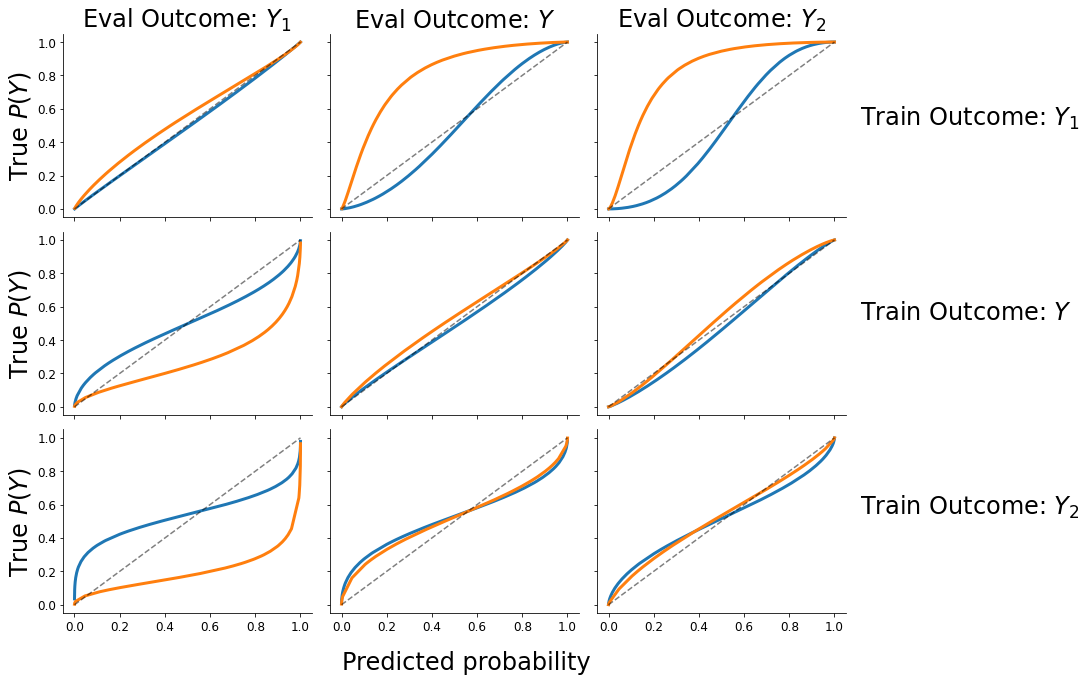

<Figure size 432x288 with 0 Axes>

In [17]:
print("Evaluation results for {}".format(dgp_types[0]))
evals = train_setups(
    dgp_types[0],
    eval_outcomes,
    features,
    sim_samples_dict,
    sim_samples_dict_eval,
)
filename_ = "./figures/surrogate_multiple_proxies_y_a_no_y2_a.pdf"
plot_multiple_surrogate(evals,dgp_types[0],filename_)

Evaluation results for y_no_a_y2_a
ModelType.GRADIENT_BOOSTING
ModelType.GRADIENT_BOOSTING
ModelType.LOGISTIC_REGRESSION
ModelType.GRADIENT_BOOSTING
ModelType.LOGISTIC_REGRESSION
ModelType.GRADIENT_BOOSTING
ModelType.GRADIENT_BOOSTING
ModelType.LOGISTIC_REGRESSION
ModelType.GRADIENT_BOOSTING
ModelType.LOGISTIC_REGRESSION
ModelType.GRADIENT_BOOSTING
ModelType.GRADIENT_BOOSTING
ModelType.LOGISTIC_REGRESSION
ModelType.GRADIENT_BOOSTING
ModelType.LOGISTIC_REGRESSION
ModelType.GRADIENT_BOOSTING
ModelType.GRADIENT_BOOSTING
ModelType.LOGISTIC_REGRESSION
ModelType.GRADIENT_BOOSTING
ModelType.LOGISTIC_REGRESSION
ModelType.GRADIENT_BOOSTING
ModelType.GRADIENT_BOOSTING
ModelType.LOGISTIC_REGRESSION
ModelType.GRADIENT_BOOSTING
ModelType.LOGISTIC_REGRESSION
ModelType.GRADIENT_BOOSTING
ModelType.GRADIENT_BOOSTING
ModelType.LOGISTIC_REGRESSION
ModelType.GRADIENT_BOOSTING
ModelType.LOGISTIC_REGRESSION
ModelType.GRADIENT_BOOSTING
ModelType.GRADIENT_BOOSTING
ModelType.LOGISTIC_REGRESSION
ModelType.GRADI

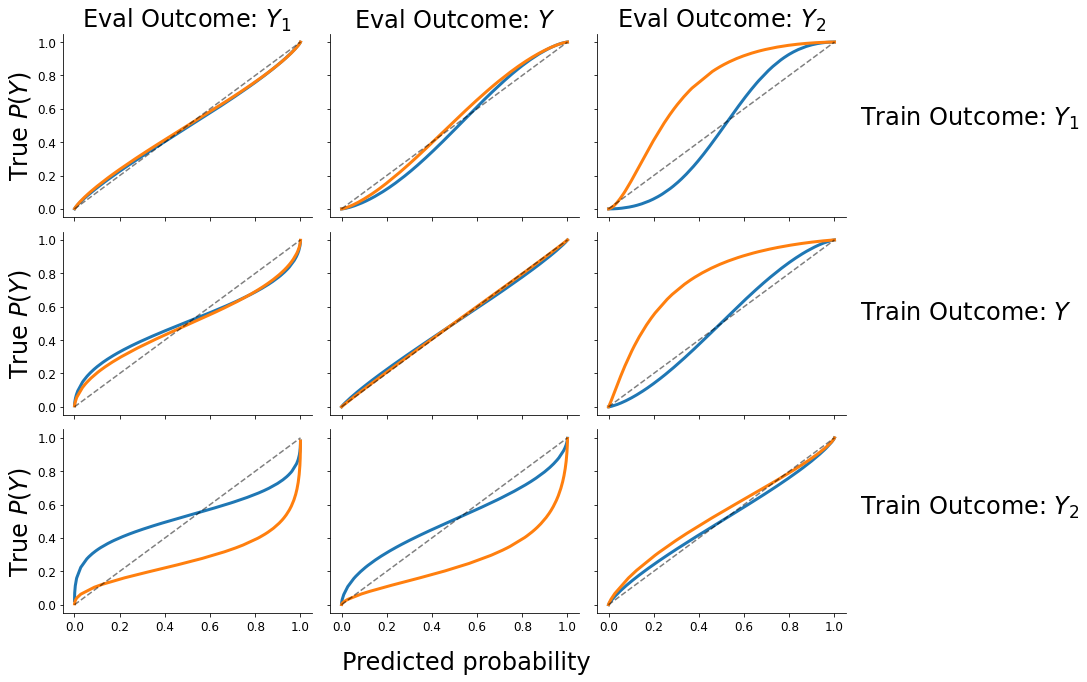

<Figure size 432x288 with 0 Axes>

In [18]:
print("Evaluation results for {}".format(dgp_types[1]))
evals_1 = train_setups(
    dgp_types[1],
    eval_outcomes,
    features,
    sim_samples_dict,
    sim_samples_dict_eval,
)
filename_ = "./figures/surrogate_multiple_proxies_no_y_a_y2_a.pdf"
plot_multiple_surrogate(evals_1,dgp_types[1],filename_)

Evaluation results for y_a_y2_a
ModelType.GRADIENT_BOOSTING
ModelType.GRADIENT_BOOSTING
ModelType.LOGISTIC_REGRESSION
ModelType.GRADIENT_BOOSTING
ModelType.LOGISTIC_REGRESSION
ModelType.GRADIENT_BOOSTING
ModelType.GRADIENT_BOOSTING
ModelType.LOGISTIC_REGRESSION
ModelType.GRADIENT_BOOSTING
ModelType.LOGISTIC_REGRESSION
ModelType.GRADIENT_BOOSTING
ModelType.GRADIENT_BOOSTING
ModelType.LOGISTIC_REGRESSION
ModelType.GRADIENT_BOOSTING
ModelType.LOGISTIC_REGRESSION
ModelType.GRADIENT_BOOSTING
ModelType.GRADIENT_BOOSTING
ModelType.LOGISTIC_REGRESSION
ModelType.GRADIENT_BOOSTING
ModelType.LOGISTIC_REGRESSION
ModelType.GRADIENT_BOOSTING
ModelType.GRADIENT_BOOSTING
ModelType.LOGISTIC_REGRESSION
ModelType.GRADIENT_BOOSTING
ModelType.LOGISTIC_REGRESSION
ModelType.GRADIENT_BOOSTING
ModelType.GRADIENT_BOOSTING
ModelType.LOGISTIC_REGRESSION
ModelType.GRADIENT_BOOSTING
ModelType.LOGISTIC_REGRESSION
ModelType.GRADIENT_BOOSTING
ModelType.GRADIENT_BOOSTING
ModelType.LOGISTIC_REGRESSION
ModelType.GRADIENT

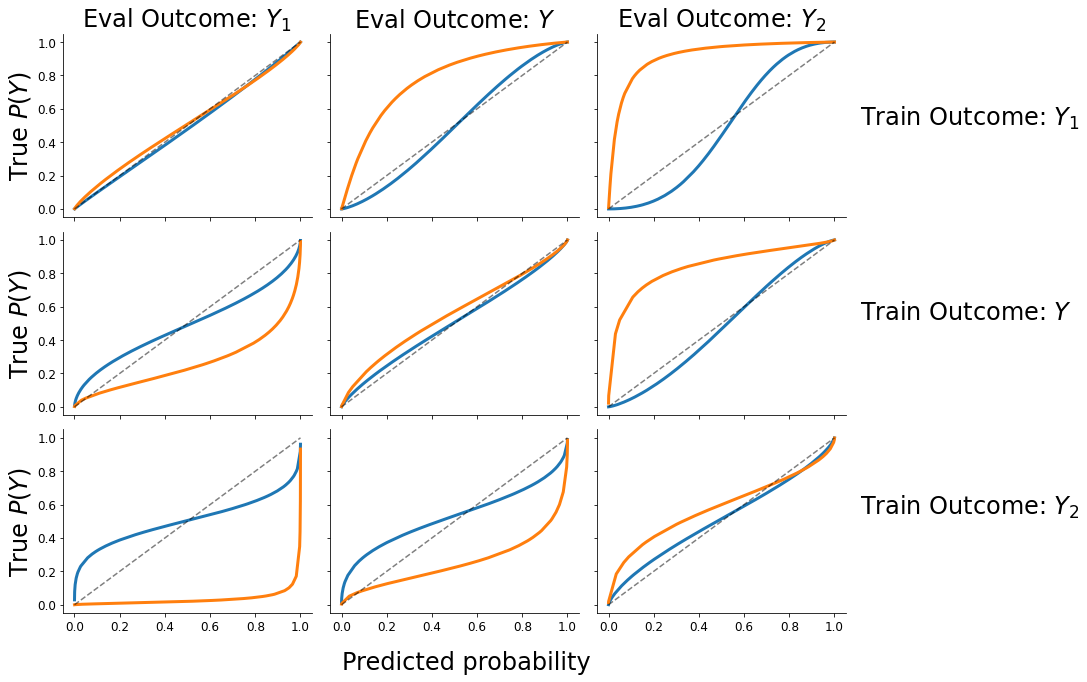

<Figure size 432x288 with 0 Axes>

In [19]:
print("Evaluation results for {}".format(dgp_types[2]))
evals_1 = train_setups(
    dgp_types[2],
    eval_outcomes,
    features,
    sim_samples_dict,
    sim_samples_dict_eval,
)
filename_ = "./figures/sufficiency_simulation_surrrogatemultiple_proxies.pdf"
plot_multiple_surrogate(evals_1,dgp_types[2],filename_)